In [27]:
import re
import nltk
import itertools
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

In [4]:
train_df = pd.read_csv('translated_with_api/translated_train_clean.csv')
train_df.head(10)

,Statement,Label
0,"""Λέει ότι η πολιτική ομάδα Annies List υποστηρ...",False
1,"""Πότε άρχισε η παρακμή του άνθρακα; Ξεκίνησε ό...",True
2,"""Η Χίλαρι Κλίντον συμφωνεί με τον Τζον Μακέιν ...",True
3,"""Η νομοθεσία για τη μεταρρύθμιση της υγειονομι...",False
4,"""Η οικονομική ανάκαμψη ξεκίνησε στο τέλος της ...",True
5,"""Οι Chicago Bears είχαν περισσότερους αρχηγούς...",True
6,"""Ο Jim Dunnam δεν έχει ζήσει στην περιοχή που ...",False
7,"""Είμαι ο μόνος άνθρωπος σε αυτή τη σκηνή που ε...",True
8,"""Ωστόσο, χρειάστηκαν 19,5 εκατομμύρια δολάρια ...",True
9,"""Λέει ότι οι πρωτοβάθμιοι αντίπαλοι του GOP Gl...",True


<AxesSubplot:xlabel='Label', ylabel='count'>

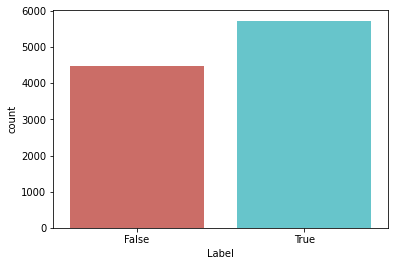

In [5]:
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

In [6]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()  
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10198 entries, 0 to 10197
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  10198 non-null  object
 1   Label      10198 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 89.8+ KB
check finished.


In [7]:
label_train = train_df.Label

In [8]:
train_df = train_df.drop('Label', axis=1)

In [9]:
train_df.head(10)

,Statement
0,"""Λέει ότι η πολιτική ομάδα Annies List υποστηρ..."
1,"""Πότε άρχισε η παρακμή του άνθρακα; Ξεκίνησε ό..."
2,"""Η Χίλαρι Κλίντον συμφωνεί με τον Τζον Μακέιν ..."
3,"""Η νομοθεσία για τη μεταρρύθμιση της υγειονομι..."
4,"""Η οικονομική ανάκαμψη ξεκίνησε στο τέλος της ..."
5,"""Οι Chicago Bears είχαν περισσότερους αρχηγούς..."
6,"""Ο Jim Dunnam δεν έχει ζήσει στην περιοχή που ..."
7,"""Είμαι ο μόνος άνθρωπος σε αυτή τη σκηνή που ε..."
8,"""Ωστόσο, χρειάστηκαν 19,5 εκατομμύρια δολάρια ..."
9,"""Λέει ότι οι πρωτοβάθμιοι αντίπαλοι του GOP Gl..."


In [10]:
train_df.shape

(10198, 1)

In [11]:
train_df['Statement'][288]

'"Ενώ αγωνιζόταν για την αυστηροποίηση των ποινών για διακρίσεις λόγω φύλου στον χώρο εργασίας, ο γερουσιαστής Glenn Grothman δήλωσε ότι δεν πιστεύει ότι οι γυναίκες ανήκουν στον χώρο εργασίας, αλλά ότι ανήκουν στο σπίτι, στο μαγείρεμα, στην καθαριότητα και στη γέννα."'

In [12]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('greek'))

In [13]:
for x in range(len(train_df)):
    corpus = []
    review = train_df['Statement'][x]
    review = re.sub(r'[^α-ωΑ-ΩίϊΐόάέύϋΰήώΊΪΌΆΈΎΫΉΏ\s]', '', review)
    review = nltk.word_tokenize(review)
    for y in review:
        if y not in stpwrds:  # stopwords are lowercase
            corpus.append(lemmatizer.lemmatize(y.upper()))  # lemmatizer's input must be uppercase
    review = ' '.join(corpus)
    train_df['Statement'][x] = review


In [14]:
train_df.head(15)

,Statement
0,ΛΈΕΙ ΌΤΙ ΠΟΛΙΤΙΚΉ ΟΜΆΔΑ ΥΠΟΣΤΗΡΊΖΕΙ ΑΜΒΛΏΣΕΙΣ ...
1,ΠΌΤΕ ΆΡΧΙΣΕ ΠΑΡΑΚΜΉ ΆΝΘΡΑΚΑ ΞΕΚΊΝΗΣΕ ΌΤΑΝ ΦΥΣΙ...
2,Η ΧΊΛΑΡΙ ΚΛΊΝΤΟΝ ΣΥΜΦΩΝΕΊ ΤΖΟΝ ΜΑΚΈΙΝ ΨΗΦΊΖΟΝΤ...
3,Η ΝΟΜΟΘΕΣΊΑ ΤΗ ΜΕΤΑΡΡΎΘΜΙΣΗ ΤΗΣ ΥΓΕΙΟΝΟΜΙΚΉΣ Π...
4,Η ΟΙΚΟΝΟΜΙΚΉ ΑΝΆΚΑΜΨΗ ΞΕΚΊΝΗΣΕ ΤΈΛΟΣ ΤΗΣ ΘΗΤΕΊ...
5,ΟΙ ΕΊΧΑΝ ΠΕΡΙΣΣΌΤΕΡΟΥΣ ΑΡΧΗΓΟΎΣ ΤΕΛΕΥΤΑΊΑ ΧΡΌΝ...
6,Ο ΈΧΕΙ ΖΉΣΕΙ ΠΕΡΙΟΧΉ ΕΚΠΡΟΣΩΠΕΊ ΕΔΏ ΧΡΌΝΙΑ
7,ΕΊΜΑΙ ΜΌΝΟΣ ΆΝΘΡΩΠΟΣ ΑΥΤΉ ΤΗ ΣΚΗΝΉ ΕΡΓΆΣΤΗΚΕ Ε...
8,ΩΣΤΌΣΟ ΧΡΕΙΆΣΤΗΚΑΝ ΕΚΑΤΟΜΜΎΡΙΑ ΔΟΛΆΡΙΑ ΚΟΝΔΎΛΙ...
9,ΛΈΕΙ ΌΤΙ ΠΡΩΤΟΒΆΘΜΙΟΙ ΑΝΤΊΠΑΛΟΙ ΈΔΩΣΑΝ ΜΙΑ ΣΥΜ...


In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df['Statement'], label_train, test_size=0.3, random_state=1)

In [18]:
X_train
X_train.shape

(7138,)

In [19]:
Y_train

1598      True
10030     True
7931     False
9215      True
6859     False
         ...  
2895      True
7813     False
905       True
5192     False
235      False
Name: Label, Length: 7138, dtype: bool

In [20]:
tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [21]:
tfidf_X_train.shape

(7138, 14056)

In [23]:
classifier = PassiveAggressiveClassifier()
classifier.fit(tfidf_X_train, Y_train)

PassiveAggressiveClassifier()

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 55.49%
Confusion matrix, without normalization


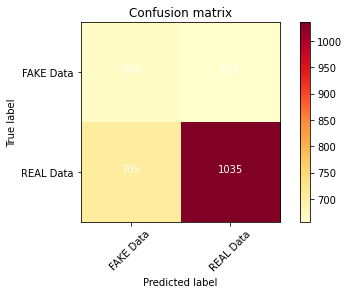

In [35]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])